In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.utils import shuffle
from sklearn.utils import check_random_state
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances                 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import make_blobs

from scipy.sparse import csr_matrix 

import pandas as pd
import numpy as np
import sys      
import os
%matplotlib inline

# Running kmeans in sci-kit learn

Text(0.5,1,'Create random blobs')

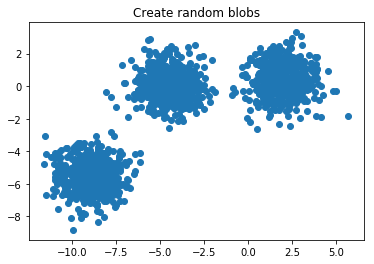

In [25]:
n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

plt.scatter(X[:, 0], X[:, 1])
plt.title("Create random blobs")

Text(0.5,1,'Incorrect Number of Blobs')

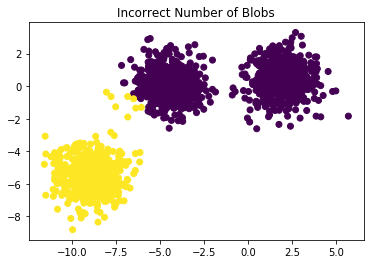

In [26]:
# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

Text(0.5,1,'correct Number of Blobs')

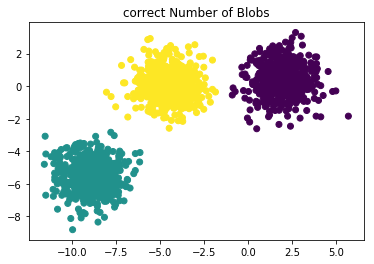

In [27]:
# Incorrect number of clusters
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("correct Number of Blobs")

# Task1: Understanding initialization impact on convergence

In [28]:
random_state = np.random.RandomState(0)

# Datasets generation parameters
n_samples_per_center = 100
grid_size = 3
scale = 0.1
n_clusters = grid_size ** 2

def make_data(random_state, n_samples_per_center, grid_size, scale):
    random_state = check_random_state(random_state)
    centers = np.array([[i, j]
                        for i in range(grid_size)
                        for j in range(grid_size)])
    n_clusters_true, n_features = centers.shape

    noise = random_state.normal(
        scale=scale, size=(n_samples_per_center, centers.shape[1]))

    X = np.concatenate([c + noise for c in centers])
    y = np.concatenate([[i] * n_samples_per_center
                        for i in range(n_clusters_true)])
    return shuffle(X, y, random_state=random_state)



## Kmeans initialisation effect

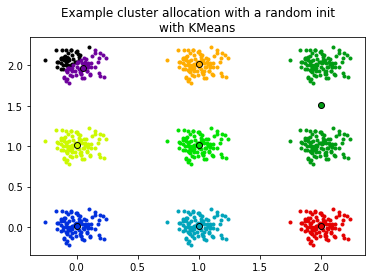

In [29]:
X, y = make_data(random_state, n_samples_per_center, grid_size, scale)
km = KMeans(n_clusters=n_clusters, init='random', n_init=1,
                     random_state=random_state).fit(X)

plt.figure()
for k in range(n_clusters):
    my_members = km.labels_ == k
    color = cm.nipy_spectral(float(k) / n_clusters, 1)
    plt.plot(X[my_members, 0], X[my_members, 1], 'o', marker='.', c=color)
    cluster_center = km.cluster_centers_[k]
    plt.plot(cluster_center[0], cluster_center[1], 'o',
             markerfacecolor=color, markeredgecolor='k', markersize=6)
    plt.title("Example cluster allocation with a random init\n"
              "with KMeans")

plt.show()

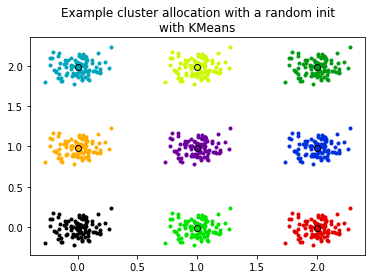

In [30]:
X, y = make_data(random_state, n_samples_per_center, grid_size, scale)
km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1,
                     random_state=random_state).fit(X)

plt.figure()
for k in range(n_clusters):
    my_members = km.labels_ == k
    color = cm.nipy_spectral(float(k) / n_clusters, 1)
    plt.plot(X[my_members, 0], X[my_members, 1], 'o', marker='.', c=color)
    cluster_center = km.cluster_centers_[k]
    plt.plot(cluster_center[0], cluster_center[1], 'o',
             markerfacecolor=color, markeredgecolor='k', markersize=6)
    plt.title("Example cluster allocation with a random init\n"
              "with KMeans")

plt.show()

## Inertia measure

Evaluation of KMeans with k-means++ init
Evaluation of KMeans with random init


Text(0.5,1,'Mean inertia for various k-means init across 10 runs')

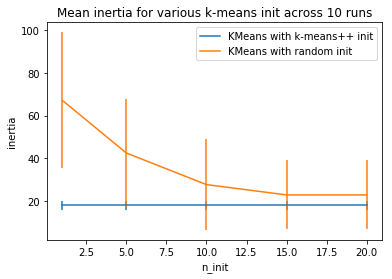

In [23]:
# Number of time the k-means algorithm will be run with different
# centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
n_init_range = np.array([1, 5, 10, 15, 20])

# Number of run (with randomly generated dataset) for each strategy so as
# to be able to compute an estimate of the standard deviation
n_runs = 10

plt.figure()
plots = []
legends = []

cases = [
    (KMeans, 'k-means++', {}),
    (KMeans, 'random', {}),
]

for factory, init, params in cases:
    print("Evaluation of %s with %s init" % (factory.__name__, init))
    inertia = np.empty((len(n_init_range), n_runs))

    for run_id in range(n_runs):
        X, y = make_data(run_id, n_samples_per_center, grid_size, scale)
        for i, n_init in enumerate(n_init_range):
            km = factory(n_clusters=n_clusters, init=init, random_state=run_id,
                         n_init=n_init, **params).fit(X)
            inertia[i, run_id] = km.inertia_
    p = plt.errorbar(n_init_range, inertia.mean(axis=1), inertia.std(axis=1))
    plots.append(p[0])
    legends.append("%s with %s init" % (factory.__name__, init))

plt.xlabel('n_init')
plt.ylabel('inertia')
plt.legend(plots, legends)
plt.title("Mean inertia for various k-means init across %d runs" % n_runs)



# Task 2: Use k-means to cluster wikipedia articles

## Compute TF-IDF

In [11]:
# import text documents from wikipedia abstracts
wiki_data=pd.read_csv('../people_wiki.txt',delimiter='\t', index_col='name')['text']

wiki_data.head()

name
David Morgan (cricket administrator)    frederick david morgan obe dl born 6 october 1...
Ingrid Schulerud                        ingrid schulerud born 8 july 1959 is a norwegi...
Howard Engel                            howard engel cm born april 2 1931 is a canadia...
Craig Spence (archaeology)              craig spence is an historian and archaeologist...
Colleen V. Chien                        colleen v chien is a senior advisor for intell...
Name: text, dtype: object

In [12]:
#Define the TFIDF vectorizer that will be used to process the data
tfidf_vectorizer = TfidfVectorizer()
#Apply this vectorizer to the full dataset to create normalized vectors
tf_idf = tfidf_vectorizer.fit_transform(wiki_data)

## Choose the right number of k

In [13]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.title('K vs. Inertia')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [14]:
heterogeneity_values = []
k_list = [2, 10, 25, 50, 100, 300]

In [15]:
##### TAKES FOREVER TO RUN#####
for n_clusters in k_list:
    km = KMeans(n_clusters=n_clusters, init='k-means++').fit(tf_idf)
    heterogeneity_values.append(km.inertia_)


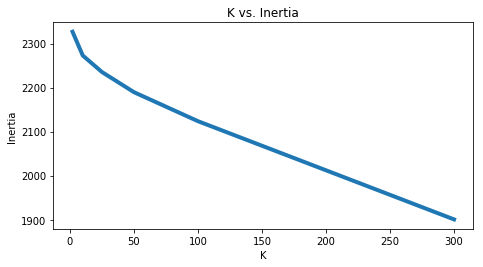

In [16]:
plot_k_vs_heterogeneity(k_list, heterogeneity_values)

In [17]:
# compute kmeans using random initialization
kmeans = KMeans(n_clusters=100, init='random').fit(tf_idf)  
# predict the closest cluster for each point
labels= kmeans.predict(tf_idf)

In [18]:
# retrieve other pages from a cluster
def get_cluster(cluster_nb, labels, dataset):
    curr_cluster=[]
    abstract=[]
    for index in range(len(labels)):
        if labels[index]==cluster_nb:
            curr_cluster.append(dataset.index.values[index,])
            abstract.append(dataset.iloc[index,])
            
    result = pd.DataFrame({'names': curr_cluster,
                           'abstract': abstract})
    return result
        

In [19]:
# Find the cluster in which Dr. Dre is
pos = wiki_data.index.get_loc("Dr. Dre")
labels[pos]

11

In [20]:
cluster= get_cluster(labels[pos], labels, wiki_data)
cluster

,names,abstract
0,Jung Joon-young,jung joonyoung hangul hanja born february 21 1...
1,C.H. Greenblatt,carl harvey ch greenblatt born june 17 1972 is...
2,YZ (rapper),yz aka anthony hill aka umar said ihsan is a e...
3,Ian Ritchie (producer),ian ritchie is a composer producer arranger an...
4,Paul Brill,paul brill is an american multiple emmy awardn...
5,Tame One,rahem brown born march 20 1970 better known by...
6,Andy Barlow (producer),andy barlow is a british producer and artist m...
7,Afrika Islam,afrika islam real name charles glenn born in 1...
8,Nump,nump trump is a filipino american hip hop arti...
9,Dr. Dre,andre romelle young born february 18 1965 know...


In [21]:
# try to get a smarter initialization?
# compute kmeans using random initialization
kmeans = KMeans(n_clusters=20, init='k-means++').fit(tf_idf)  
# predict the closest cluster for each point
labels= kmeans.predict(tf_idf)
# Find the cluster in which Taika Waititi is
pos = wiki_data.index.get_loc("Dr. Dre")
labels[pos]
# get cluster
cluster= get_cluster(labels[pos], labels, wiki_data)
cluster

,names,abstract
0,Kristy Starling,kristy starling is a contemporary christian mu...
1,Ra McGuire,ramon wayne ra mcguire born june 13 1950 in va...
2,Zebra Katz,zebra katz is the stage name of ojay morgan an...
3,Richard Elliot,richard elliot born january 16 1960 in glasgow...
4,Arthur Brown (musician),arthur brown born arthur wilton brown on 24 ju...
5,Paul Shull,paul james shull born may 25 1973 is a canadia...
6,"Peter, Sue and Marc",peter sue and marc were a swiss music group fr...
7,Phil Bardowell,philip bardowell was born in kingston jamaica ...
8,Anssi Kela,anssi kela born 29 july 1972 in kerava finland...
9,Nina Miranda,nina miranda is both a singer and songwriter w...


# LDA modeling

In [22]:
# import text documents from wikipedia abstracts
wiki_data=pd.read_csv('../people_wiki.txt',delimiter='\t', index_col='name')['text']

wiki_data.head()
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(wiki_data)
tf_feature_names = tf_vectorizer.get_feature_names()

In [23]:
no_topics = 20
# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics).fit(tf)

/Users/aponsero/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


# Display and evaluate topics

In [24]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
president served university director board business national international executive school
Topic 1:
new novel appeared york won world born published book award
Topic 2:
news television radio born reporter new worked host poker career
Topic 3:
film art series new television work born theatre festival award
Topic 4:
law state court university district judge states united served senate
Topic 5:
club cup played team season won league football rugby player
Topic 6:
university music research professor american new college institute science award
Topic 7:
radio music new bbc television world years including year series
Topic 8:
university book law published new books american professor school history
Topic 9:
world won born international national 2008 new years 2011 member
Topic 10:
tour won championship racing open golf team finished born pga
Topic 11:
music album band released records song songs born jazz albums
Topic 12:
world championships marathon metres won time record olympic

In [25]:
# transform method returns a matrix with one line per document, columns being topics weight
predict = lda.transform(tf)
result = pd.DataFrame(predict).set_index(wiki_data.reset_index()['name'])

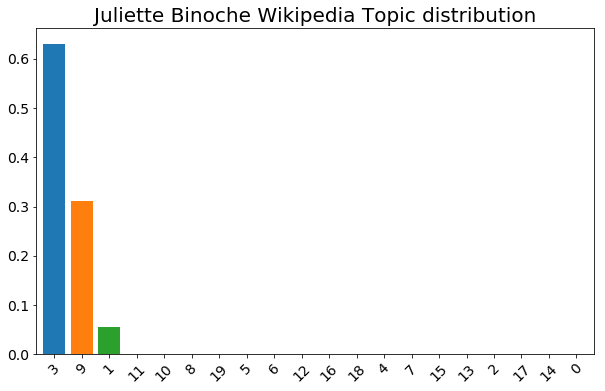

In [26]:
# get distribution of topics for Juliette Binoche
d = pd.Series(result.loc["Juliette Binoche"]).sort_values(ascending=False)

ax = d.plot(kind='bar', title='Juliette Binoche Wikipedia Topic distribution',
            figsize=(10,6), width=.8, fontsize=14, rot=45 )

ax.title.set_size(20)

In [27]:
# Adjust (less or more topics) and rerun the LDA model
no_topics = 10
# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics).fit(tf)

/Users/aponsero/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [28]:
#display best word by topic
no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
law university court judge school received american born united states
Topic 1:
university new research american college york professor institute book award
Topic 2:
world born won race racing marathon championships best year metres
Topic 3:
canadian born states court united years won received car district
Topic 4:
university member party served state born election minister elected national
Topic 5:
world won team coach hockey national championships season born championship
Topic 6:
played league season team career born football games club player
Topic 7:
president board served company new university director years born chairman
Topic 8:
music album band released born new known song records songs
Topic 9:
film new television series award born art work york theatre


In [29]:
# transform method returns a matrix with one line per document, columns being topics weight
predict = lda.transform(tf)
result = pd.DataFrame(predict).set_index(wiki_data.reset_index()['name'])

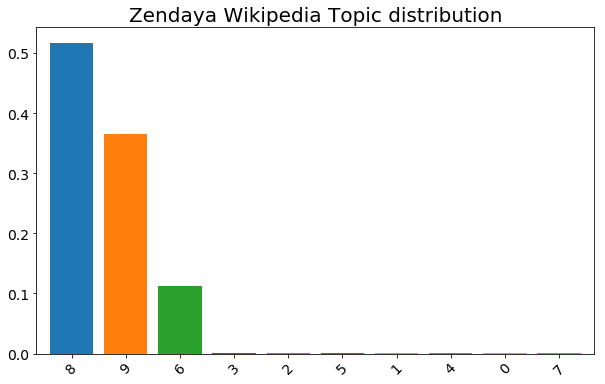

In [30]:
# get distribution of topics for Zendaya
d = pd.Series(result.loc["Zendaya"]).sort_values(ascending=False)

ax = d.plot(kind='bar', title='Zendaya Wikipedia Topic distribution',
            figsize=(10,6), width=.8, fontsize=14, rot=45 )

ax.title.set_size(20)